In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torch import nn

In [4]:
from utils import train_loop

In [5]:
import os
from pathlib import Path


os.chdir(Path(os.getcwd()).parent)

In [6]:
from models import LSTMLabelEndClassifier

In [7]:
RANDOM_STATE = 42

In [8]:
rcParams['figure.figsize'] = (13, 7)

Loading data

In [9]:
import json

from nltk.stem import PorterStemmer, SnowballStemmer

from document_dataset import LabeledDocumentDataset, DocumentDataset


with open('data/word_idx_snowball.json') as f:
    word_idx = json.load(f)


stemmer = SnowballStemmer('russian')
with open('data/first_label_train.json') as first_train, open('data/first_label_test.json') as first_test:
    first_train_dataset = LabeledDocumentDataset(json.load(first_train), word_idx, stemmer=stemmer, max_document_length=800, add_end_token=True)
    first_test_dataset = LabeledDocumentDataset(json.load(first_test), word_idx, stemmer=stemmer, max_document_length=800, add_end_token=True)

In [10]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(first_train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(first_test_dataset, batch_size=500)

Training

In [16]:
from importlib import reload
import models
LSTMLabelEndClassifier = reload(models).LSTMLabelEndClassifier

One pass one layer with linear layer projection LSTM

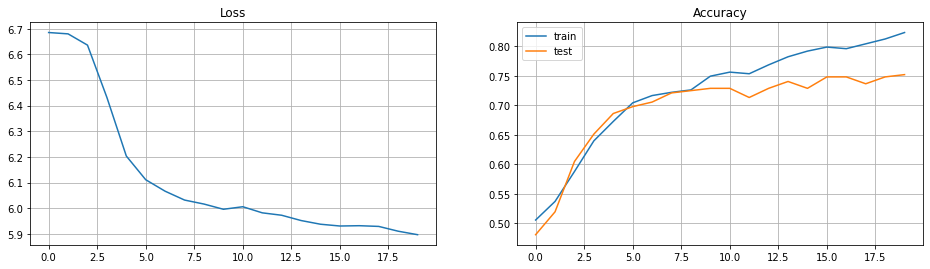

In [12]:
first_label_start_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.2
)

train_loop(20, 0.002, first_label_start_clf)

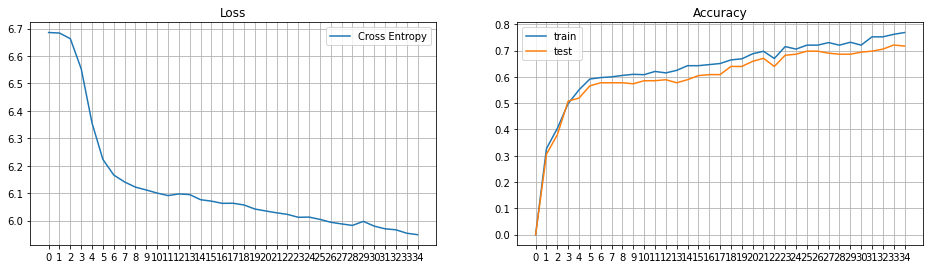

In [45]:
first_label_end_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
)

train_loop(
    n_epoch=35, 
    lr=0.002,
    clf=first_label_end_clf,
    train_on_start=False
)

Trying bidirectional (outputs are concatenated)

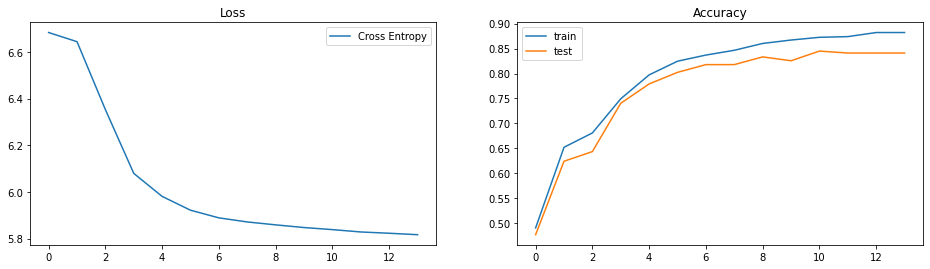

KeyboardInterrupt: 

In [17]:
first_label_start_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    lr=0.002,
    clf=first_label_start_bidir_clf,
    train_on_start=True
)


In [ ]:
first_label_start_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=first_label_start_bidir_clf,
    train_on_start=True
)


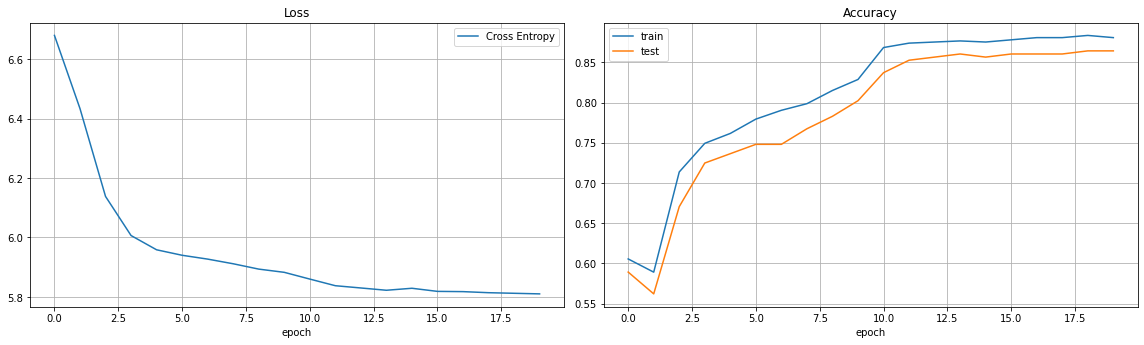

In [12]:
first_label_start_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=32,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=first_label_start_bidir_clf,
    train_on_start=True
)


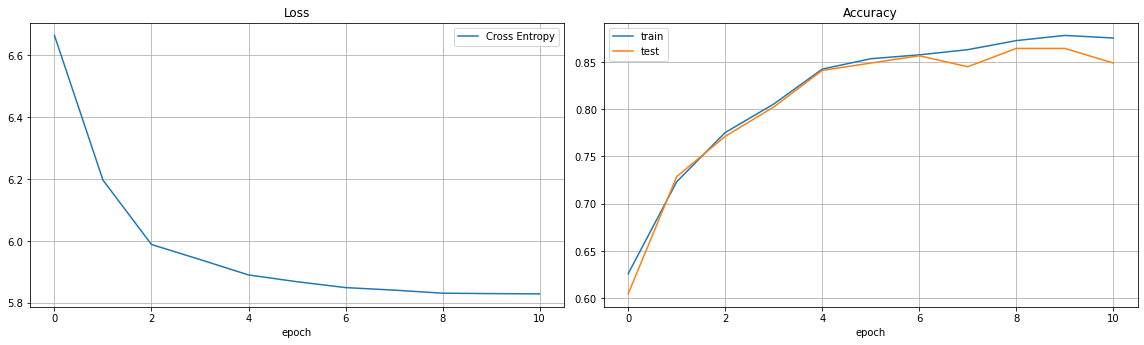

KeyboardInterrupt: 

In [13]:
first_label_start_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=64,
    embedding_dim=32,
    dropout=0.3,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=first_label_start_bidir_clf,
    train_on_start=True
)


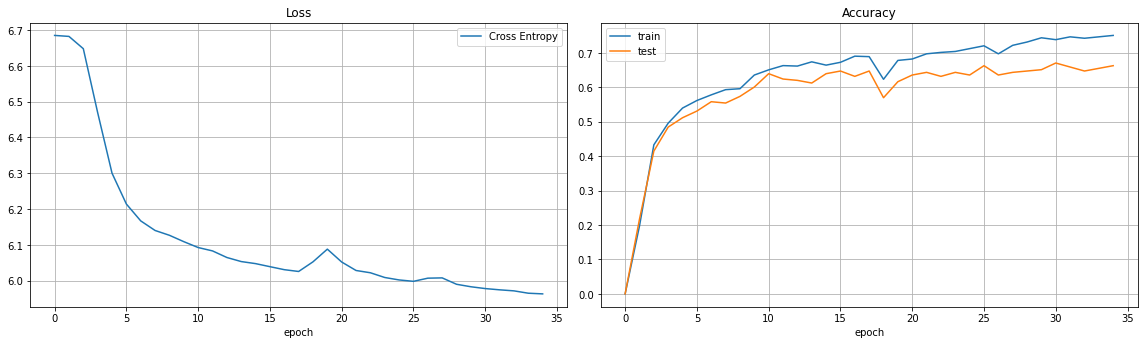

In [26]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=16,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=35,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


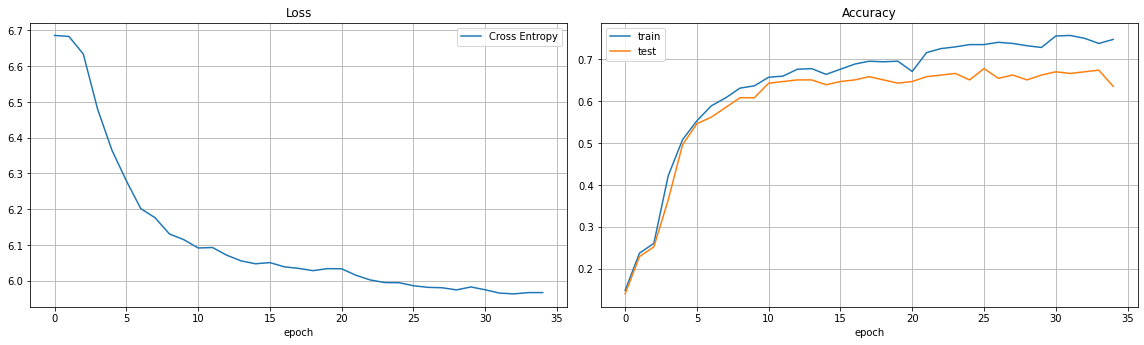

In [23]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=16,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=35,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


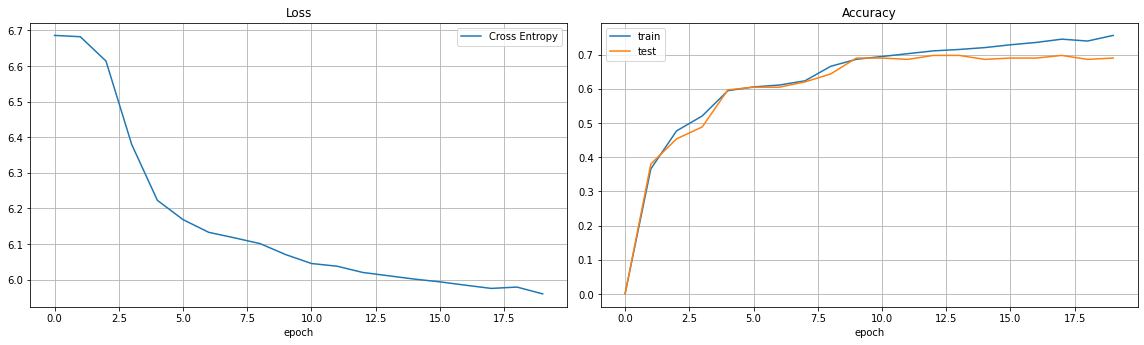

In [19]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


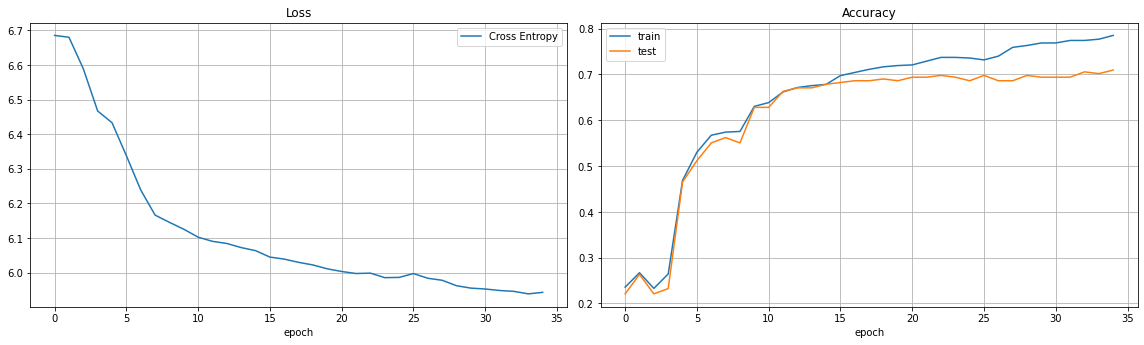

In [25]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=35,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


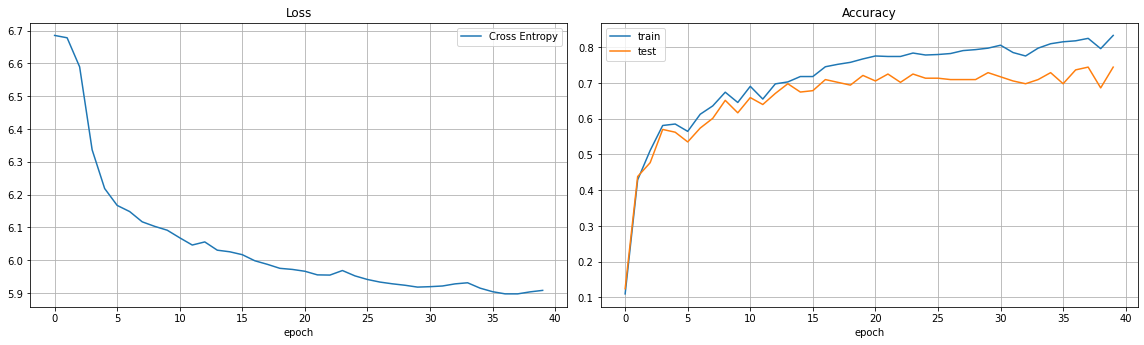

In [24]:

first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.3,
    bidirectional=True,
)

train_loop(
    n_epoch=40,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


Experiments with projection

In [27]:

class LSTMLabelEndClassifier(torch.nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        hidden_size: int,
        num_layers=1,
        embedding_dim=256,
        dropout=0,
        bidirectional=False
    ):
        super().__init__()

        self.bidirectional = bidirectional

        self.embedding = torch.nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=0,
        )
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        proj_hidden_size = hidden_size * 2 if self.bidirectional else hidden_size
        self.project = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.Linear(proj_hidden_size, proj_hidden_size),
            nn.LeakyReLU(0.1),
            torch.nn.Linear(proj_hidden_size, 1)
        )
        self.softmax = torch.nn.Softmax(1)

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        output, _ = (self.lstm(self.embedding(batch)))

        return self.softmax(self.project(output)).flatten(1)


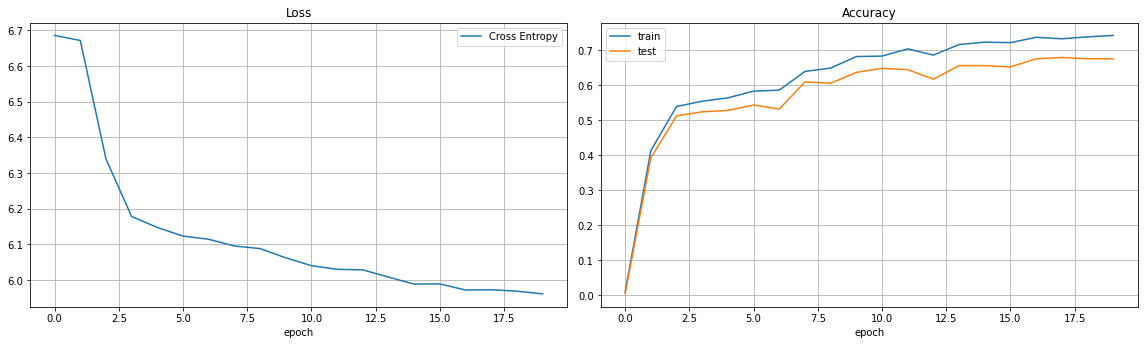

In [28]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


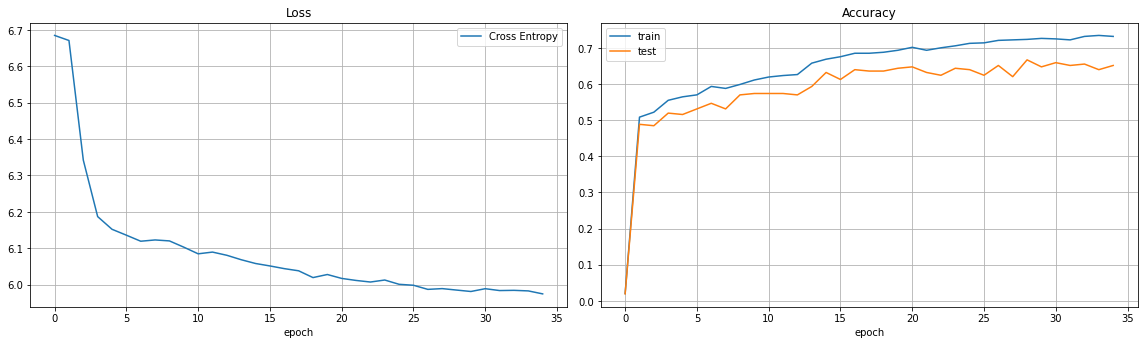

In [32]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=35,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


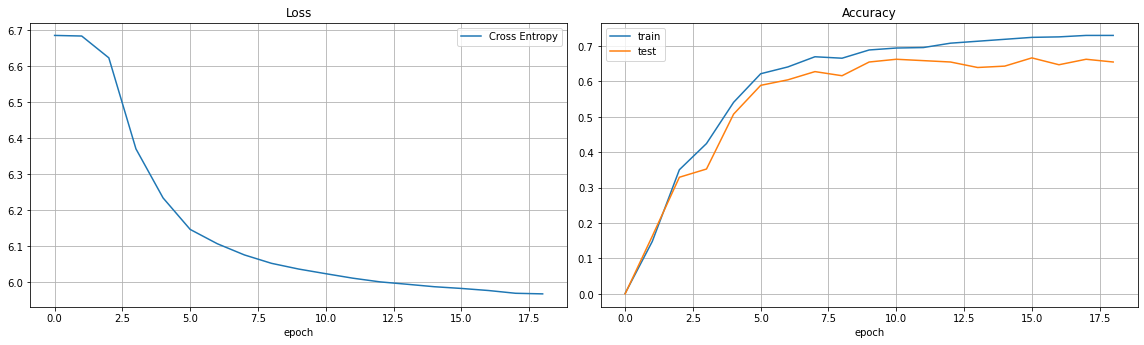

KeyboardInterrupt: 

In [34]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=8,
    embedding_dim=32,
    dropout=0.0,
    bidirectional=True,
)

train_loop(
    n_epoch=30,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


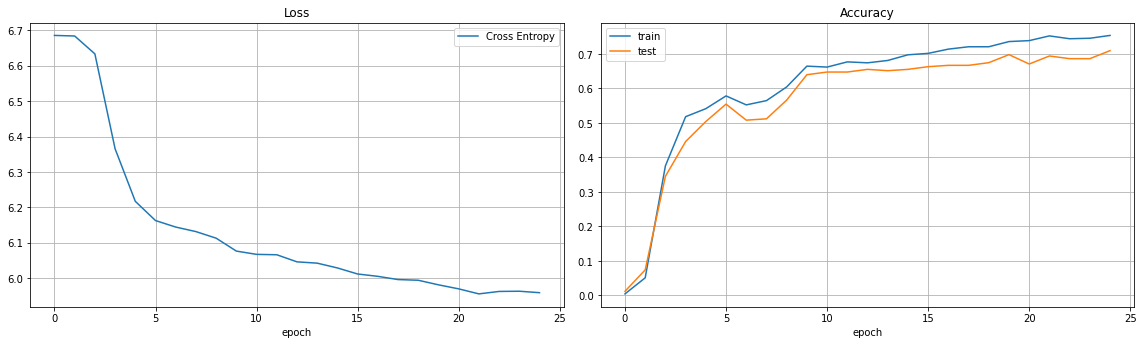

In [31]:

first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=8,
    embedding_dim=32,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=25,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


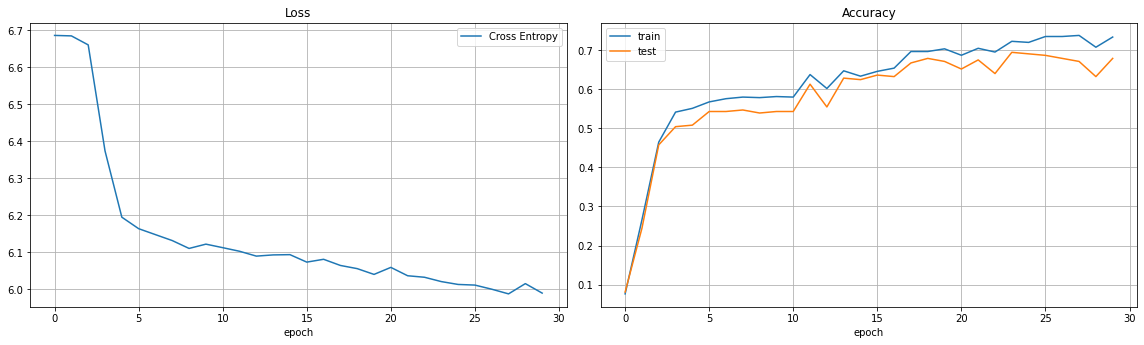

In [33]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    hidden_size=8,
    embedding_dim=32,
    dropout=0.2,
    bidirectional=True,
)

train_loop(
    n_epoch=30,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


In [45]:
class LSTMLabelEndClassifier(torch.nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        hidden_size: int,
        num_layers=1,
        embedding_dim=256,
        dropout=0,
        bidirectional=False
    ):
        super().__init__()

        self.bidirectional = bidirectional

        self.embedding = torch.nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=0,
        )
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        proj_hidden_size = hidden_size * 2 if self.bidirectional else hidden_size
        self.project = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.Linear(proj_hidden_size, 1)
        )
        self.softmax = torch.nn.Softmax(1)

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        output, _ = (self.lstm(self.embedding(batch)))

        return self.softmax(self.project(output)).flatten(1)


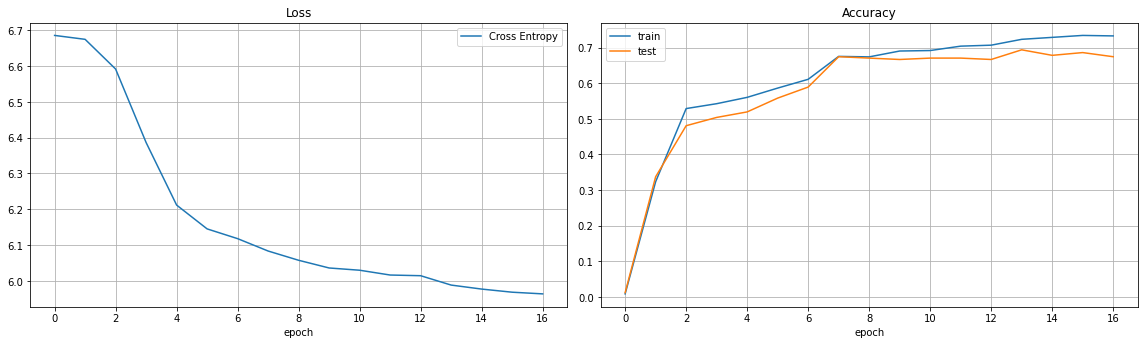

KeyboardInterrupt: 

In [46]:
first_label_end_bidir_clf = LSTMLabelEndClassifier(
    first_train_dataset.tokens_count,
    num_layers=2,
    hidden_size=16,
    embedding_dim=32,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    lr=0.002,
    clf=first_label_end_bidir_clf,
    train_on_start=False,
)


# Second label

In [10]:
import json

from nltk.stem import SnowballStemmer

from document_dataset import LabeledDocumentDataset, DocumentDataset


with open('data/word_idx_snowball.json') as f:
    word_idx = json.load(f)


stemmer = SnowballStemmer('russian')
with open('data/second_label_train.json') as second_train, open('data/second_label_test.json') as second_test:
    second_train_dataset = LabeledDocumentDataset(json.load(second_train), word_idx, stemmer=stemmer.stem, max_document_length=800)
    second_test_dataset = LabeledDocumentDataset(json.load(second_test), word_idx, stemmer=stemmer.stem, max_document_length=800)

In [11]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(second_train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(second_test_dataset, batch_size=500)

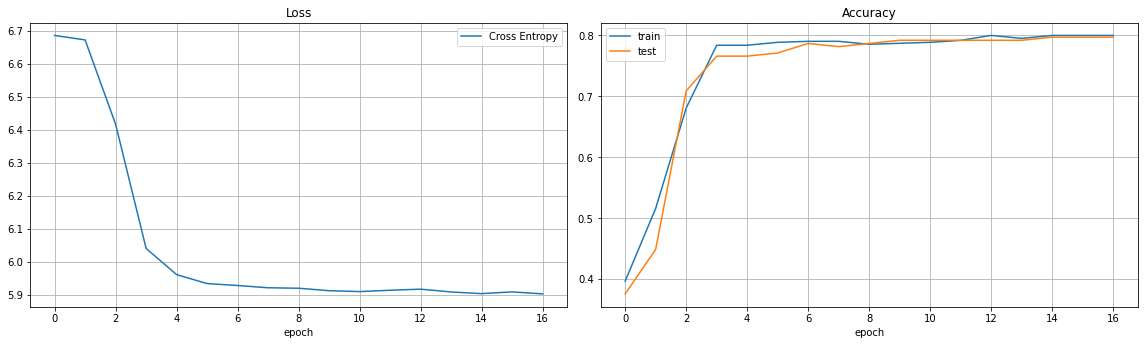

KeyboardInterrupt: 

In [29]:
second_label_start_bidir_clf = LSTMLabelEndClassifier(
    second_train_dataset.tokens_count,
    hidden_size=32,
    embedding_dim=16,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=second_label_start_bidir_clf,
    train_on_start=True
)


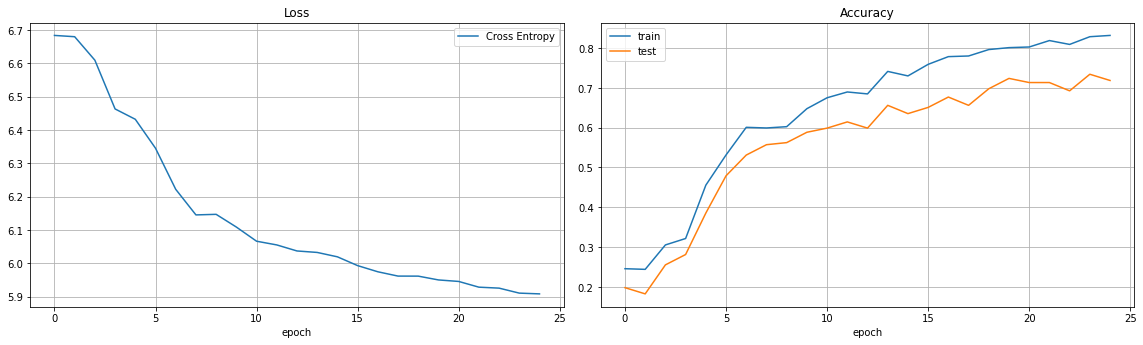

In [14]:
second_label_end_bidir_clf = LSTMLabelEndClassifier(
    len(word_idx),
    hidden_size=16,
    embedding_dim=32,
    dropout=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=25,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=second_label_end_bidir_clf,
    train_on_start=False
)
